<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>Notebook comparing diaSources with bad mask planes excluded from detection</b> <br>
Contact author: Ian Sullivan<br>
Last verified to run: 28 May 2024<br>
LSST Science Piplines version: w_2024_20 and with local ip_diffim<br>
Run with a local ap_verify run of ap_verify_ci_hits2015


## Run details

Baseline run

* Used daily `w_2024_20` for the base, local ip_diffim changes for the test
* Run locally



### 1. Main package imports

In [1]:
import os
import importlib
import pprint

In [2]:
import matplotlib.pyplot as plt
#%matplotlib widget
%matplotlib inline

import numpy as np
import pandas as pd

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [4]:
import lsst.afw.display as afwDisplay
import lsst.geom

import lsst.daf.butler as dafButler
import lsst.pipe.base

In [5]:
!eups list analysis_ap

   g68a9e33b8d+63f623853e 	w_latest w_2024_21 current
   gc75c7cc69e+e9b23c9ab0 	w_2024_20 setup


In [6]:
from lsst.analysis.ap import apdb

In [7]:
# from lsst.analysis.ap import legacyApdbUtils as utils
# from lsst.analysis.ap import legacyPlotUtils as plac
from lsst.analysis.ap import nb_utils

In [8]:
from astropy.table import Table

In [9]:
# importlib.reload(plac)

In [10]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# importlib.reload(utils)

### 2. Data access config
We are comparing multiple runs now, so we have to define where to find the data and the APDBs for each run.

#### Keys for default run.

In [11]:
!ls "../../ap_verify_output/tickets/DM-44491"

alerts         association.db pipelines
apdb.py        config         repo


In [12]:
repo = '../../ap_verify_output/w_2024_20/repo/'
collections = 'ap_verify-output'
instrument = 'DECam'
skymap = 'decam_rings_v1'

butler = dafButler.Butler(repo, collections=collections)

dbType='sqlite'
dbName = "../../ap_verify_output/w_2024_20/association.db"

reader = apdb.ApdbSqliteQuery(dbName, instrument='DECam')

In [13]:
len(reader._tables)

6

In [14]:
default_run = {
    'repo': repo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler,
    'dbType': dbType,
    'dbName': dbName,
    'reader': reader
}

In [15]:
default_run['run_name'] = 'Main'

#### This set is after merging DM-42774 which renamed mask planes inherited from the template

In [16]:
repo = '../../ap_verify_output/tickets/DM-44491/repo/'
collections = 'ap_verify-output'
instrument = 'DECam'
skymap = 'decam_rings_v1'

butler = dafButler.Butler(repo, collections=collections)

dbType='sqlite'
dbName = "../../ap_verify_output/tickets/DM-44491/association.db"

reader = apdb.ApdbSqliteQuery(dbName, instrument='DECam')

In [17]:
len(reader._tables)

6

In [18]:
test_run = {
    'repo': repo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler,
    'dbType': dbType,
    'dbName': dbName,
    'reader': reader
}

In [19]:
test_run['run_name'] = 'Exclude bad mask planes'

#### This is after adding saturatedCenterAll to the list of diaSource flags to remove

## A. Analysis of Sources

### 3. Number of detections
Now loading the tables to compare among them

In [20]:
default_run['robjTable'] = default_run['reader'].load_objects()
default_run['rsrcTable'] = default_run['reader'].load_sources()

In [21]:
test_run['robjTable'] = test_run['reader'].load_objects()
test_run['rsrcTable'] = test_run['reader'].load_sources()

Look at how many objects and sources we picked right from the reader

In [22]:
n_objs = pd.DataFrame()

In [23]:
n_objs.loc[default_run['run_name'], 'n_rdiasrc'] = len(default_run['rsrcTable'])
n_objs.loc[test_run['run_name'], 'n_rdiasrc'] = len(test_run['rsrcTable'])


In [24]:
n_objs.loc[default_run['run_name'], 'n_rdiaobj'] = len(default_run['robjTable'])
n_objs.loc[test_run['run_name'], 'n_rdiaobj'] = len(test_run['robjTable'])


In [25]:
n_objs

,n_rdiasrc,n_rdiaobj
Main,1086.0,950.0
Exclude bad mask planes,864.0,730.0


In [26]:
test_table2 = test_run['reader'].load_sources()

In [27]:
object_columns = ['diaObjectId', 'ra', 'dec', 'nDiaSources', 'g_psfFluxMean', 
                  'r_psfFluxMean', 'i_psfFluxMean', 'z_psfFluxMean', 'y_psfFluxMean',
                  'validityEnd']

In [28]:
source_columns = ['diaSourceId', 'diaObjectId', 'ra', 'dec', 'visit', 'detector', 'midpointMjdTai',
                  'apFlux', 'psfFlux', 'apFluxErr', 'psfFluxErr', 'scienceFlux', 'scienceFluxErr',
                  'snr', 'x', 'y', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'reliability', 'band',
                  'visit', 'detector', 'instrument']

In [29]:
badFlagList = [
    'pixelFlags_bad',
    'pixelFlags_suspect',
    'pixelFlags_saturatedCenter',
    'pixelFlags_interpolated',
    'pixelFlags_interpolatedCenter',
    'pixelFlags_edge',
    # 'shape_flag',
    # 'shape_flag_no_pixels',
    # 'shape_flag_not_contained',
    ]

In [30]:
source_columns.extend(badFlagList)

In [31]:
table1 = default_run['robjTable'][default_run['robjTable'].validityEnd.isnull()]

Inspect the columns of the object table

In [32]:
for c in table1.columns:
    print(c)

diaObjectId
validityStart
validityEnd
ra
raErr
dec
decErr
ra_dec_Cov
radecMjdTai
pmRa
pmRaErr
pmDec
pmDecErr
parallax
parallaxErr
pmRa_pmDec_Cov
pmRa_parallax_Cov
pmDec_parallax_Cov
pmParallaxLnL
pmParallaxChi2
pmParallaxNdata
u_psfFluxMean
u_psfFluxMeanErr
u_psfFluxSigma
u_psfFluxChi2
u_psfFluxNdata
u_fpFluxMean
u_fpFluxMeanErr
u_fpFluxSigma
g_psfFluxMean
g_psfFluxMeanErr
g_psfFluxSigma
g_psfFluxChi2
g_psfFluxNdata
g_fpFluxMean
g_fpFluxMeanErr
g_fpFluxSigma
r_psfFluxMean
r_psfFluxMeanErr
r_psfFluxSigma
r_psfFluxChi2
r_psfFluxNdata
r_fpFluxMean
r_fpFluxMeanErr
r_fpFluxSigma
i_psfFluxMean
i_psfFluxMeanErr
i_psfFluxSigma
i_psfFluxChi2
i_psfFluxNdata
i_fpFluxMean
i_fpFluxMeanErr
i_fpFluxSigma
z_psfFluxMean
z_psfFluxMeanErr
z_psfFluxSigma
z_psfFluxChi2
z_psfFluxNdata
z_fpFluxMean
z_fpFluxMeanErr
z_fpFluxSigma
y_psfFluxMean
y_psfFluxMeanErr
y_psfFluxSigma
y_psfFluxChi2
y_psfFluxNdata
y_fpFluxMean
y_fpFluxMeanErr
y_fpFluxSigma
nearbyObj1
nearbyObj1Dist
nearbyObj1LnP
nearbyObj2
nearbyObj2Dist

Inspect the columns of the source table

In [33]:
table2 = default_run['rsrcTable']

In [34]:
for c in table2.columns:
    print(c)

diaSourceId
visit
detector
diaObjectId
ssObjectId
parentDiaSourceId
ssObjectReassocTime
midpointMjdTai
ra
raErr
dec
decErr
ra_dec_Cov
x
xErr
y
yErr
x_y_Cov
centroid_flag
apFlux
apFluxErr
apFlux_flag
apFlux_flag_apertureTruncated
snr
psfFlux
psfFluxErr
psfRa
psfRaErr
psfDec
psfDecErr
psfFlux_psfRa_Cov
psfFlux_psfDec_Cov
psfRa_psfDec_Cov
psfLnL
psfChi2
psfNdata
psfFlux_flag
psfFlux_flag_edge
psfFlux_flag_noGoodPixels
trailFlux
trailFluxErr
trailRa
trailRaErr
trailDec
trailDecErr
trailLength
trailLengthErr
trailAngle
trailAngleErr
trailFlux_trailRa_Cov
trailFlux_trailDec_Cov
trailFlux_trailLength_Cov
trailFlux_trailAngle_Cov
trailRa_trailDec_Cov
trailRa_trailLength_Cov
trailRa_trailAngle_Cov
trailDec_trailLength_Cov
trailDec_trailAngle_Cov
trailLength_trailAngle_Cov
trailLnL
trailChi2
trailNdata
trail_flag_edge
dipoleMeanFlux
dipoleMeanFluxErr
dipoleFluxDiff
dipoleFluxDiffErr
dipoleRa
dipoleRaErr
dipoleDec
dipoleDecErr
dipoleLength
dipoleLengthErr
dipoleAngle
dipoleAngleErr
dipoleMeanFlux

In [35]:
visits = set(table2['visit'])

In [36]:
visits

{411371, 411420, 419802}

In [37]:
ccds = set(table2['detector'])

In [38]:
ccds

{5, 10, 56, 60}

Now filter the objects which are not valid and pick the useful columns.

In [39]:
default_run['objTable'] = default_run['robjTable'][default_run['robjTable'].validityEnd.isnull()][object_columns]
test_run['objTable'] = test_run['robjTable'][test_run['robjTable'].validityEnd.isnull()][object_columns]


In [40]:
default_run['srcTable'] = default_run['rsrcTable'][source_columns]
test_run['srcTable'] = test_run['rsrcTable'][source_columns]


Check numbers once more

In [41]:
n_objs.loc[default_run['run_name'], 'n_diasrc'] = len(default_run['srcTable'])
n_objs.loc[test_run['run_name'], 'n_diasrc'] = len(test_run['srcTable'])

In [42]:
n_objs.loc[default_run['run_name'], 'n_diaobj'] = len(default_run['objTable'])
n_objs.loc[test_run['run_name'], 'n_diaobj'] = len(test_run['objTable'])

In [43]:
n_objs

,n_rdiasrc,n_rdiaobj,n_diasrc,n_diaobj
Main,1086.0,950.0,1086.0,950.0
Exclude bad mask planes,864.0,730.0,864.0,730.0


Note that no objects were filtered out by the above check 

### 4. Flags 
Loading up the flag tables now

In [44]:
import functools
import operator

In [45]:
def add_flag_tables(run_dict, badFlagList):
    """
    Unpack the flags and add the resulting tables to the run dictionary
    """
    # run_dict['flagValues'] = unpacker.unpack(run_dict['srcTable']['flags'], 'flags')
    # run_dict['flagTable'] = pd.DataFrame(run_dict['flagValues'], index=run_dict['srcTable'].index)

    # run_dict['srcTableFlags'] = pd.merge(run_dict['srcTable'], run_dict['flagTable'], left_index=True, right_index=True)
    
    badFlags = [run_dict['srcTable'][flag] for flag in badFlagList]
    flagFilter = functools.reduce(operator.or_, badFlags)
    noFlagFilter = ~flagFilter

    run_dict['goodSrc'] = run_dict['srcTable'].loc[noFlagFilter]

    run_dict['goodObjIds'] = set(run_dict['srcTable'].loc[noFlagFilter, 'diaObjectId'])

    run_dict['goodObj'] = run_dict['objTable'].loc[run_dict['objTable']['diaObjectId'].isin(run_dict['goodObjIds'])]
    
    return flagFilter, noFlagFilter

In [46]:
flagFilter, noFlagFilter = add_flag_tables(default_run, badFlagList)
flagFilter1, noFlagFilter1 = add_flag_tables(test_run, badFlagList)

In [47]:
n_objs.loc[default_run['run_name'], 'n_good_diaobj'] = len(default_run['goodObj'])
n_objs.loc[test_run['run_name'], 'n_good_diaobj'] = len(test_run['goodObj'])

In [48]:
n_objs.loc[default_run['run_name'], 'n_good_diasrc'] = len(default_run['goodSrc'])
n_objs.loc[test_run['run_name'], 'n_good_diasrc'] = len(test_run['goodSrc'])

In [49]:
n_objs

,n_rdiasrc,n_rdiaobj,n_diasrc,n_diaobj,n_good_diaobj,n_good_diasrc
Main,1086.0,950.0,1086.0,950.0,655.0,778.0
Exclude bad mask planes,864.0,730.0,864.0,730.0,681.0,805.0


Text(0, 0.5, 'N')

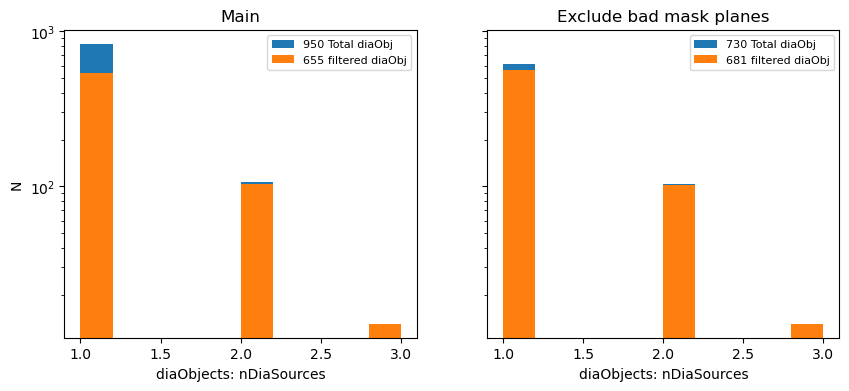

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i_run, run_dict in enumerate([default_run, test_run]):
    #plt.figure(figsize=(12, 8))
    ax = axes.flatten()[i_run]

    ax.hist(run_dict['objTable'].nDiaSources, log=True, label=f"{len(run_dict['objTable'])} Total diaObj")
    #plt.xlabel('diaObjects: nDiaSources')
    #plt.legend(loc='best')

    ax.hist(run_dict['goodObj'].nDiaSources, log=True, label=f"{len(run_dict['goodObj'])} filtered diaObj")
    ax.set_xlabel('diaObjects: nDiaSources')
    ax.legend(loc='best', fontsize=8)
    ax.set_title(run_dict['run_name'])
axes.flatten()[0].set_ylabel('N')

Small differences in good objects, a moderate difference in the total number of objects

## 4.1 Real-bogus reliability scores

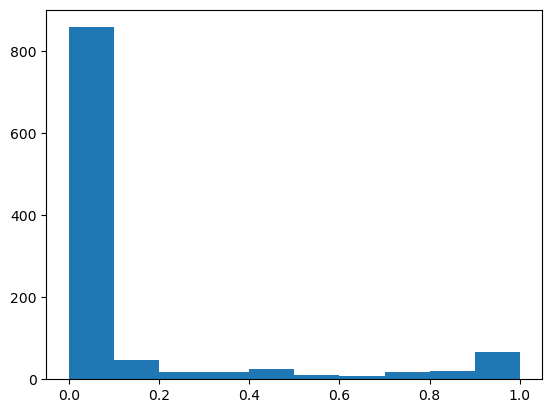

In [51]:
default_hist = plt.hist(default_run['srcTable']['reliability'])

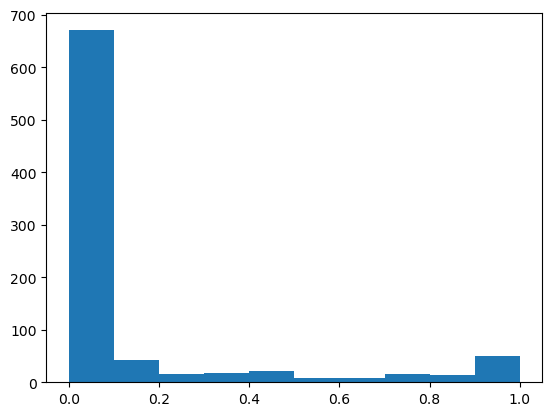

In [52]:
test_hist = plt.hist(test_run['srcTable']['reliability'])

In [53]:
reliability_table = pd.DataFrame()

In [54]:
reliability_table['reliability'] = np.around(default_hist[1][:-1], 3)

In [55]:
reliability_table[default_run['run_name']] = default_hist[0]
reliability_table[test_run['run_name']] = test_hist[0]

In [56]:
reliability_table

,reliability,Main,Exclude bad mask planes
0,0.0,858.0,670.0
1,0.1,46.0,43.0
2,0.2,17.0,16.0
3,0.3,18.0,17.0
4,0.4,24.0,21.0
5,0.5,11.0,9.0
6,0.6,8.0,8.0
7,0.7,17.0,16.0
8,0.8,20.0,14.0
9,0.9,67.0,50.0


In [57]:
print(default_hist[1][5])
print(np.sum(default_hist[0][5:]))
print(np.sum(test_hist[0][5:]))

0.49996793270143536
123.0
97.0


### Repeat with only good sources

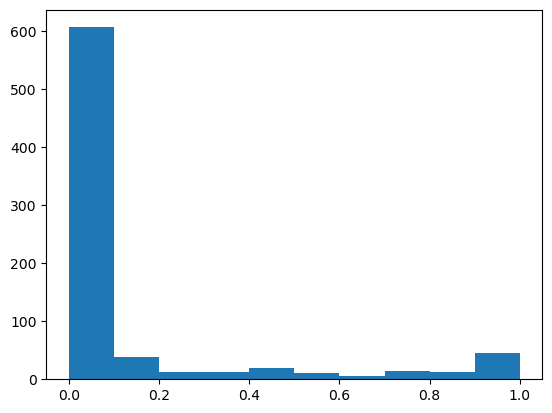

In [58]:
default_hist = plt.hist(default_run['goodSrc']['reliability'])

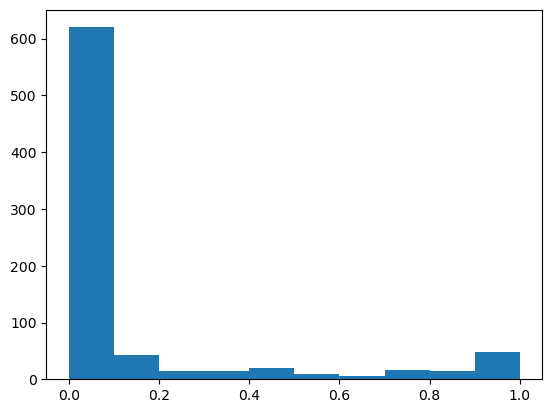

In [59]:
test_hist = plt.hist(test_run['goodSrc']['reliability'])

In [60]:
reliability_table = pd.DataFrame()

In [61]:
reliability_table = pd.DataFrame()
reliability_table['reliability'] = np.around(default_hist[1][:-1], 3)
reliability_table[default_run['run_name']] = default_hist[0]
reliability_table[test_run['run_name']] = test_hist[0]

In [62]:
reliability_table[default_run['run_name']] = default_hist[0]
reliability_table[test_run['run_name']] = test_hist[0]

In [63]:
reliability_table

,reliability,Main,Exclude bad mask planes
0,0.0,606.0,620.0
1,0.1,39.0,43.0
2,0.2,13.0,15.0
3,0.3,13.0,15.0
4,0.4,19.0,19.0
5,0.5,10.0,9.0
6,0.6,6.0,6.0
7,0.7,14.0,16.0
8,0.8,13.0,14.0
9,0.9,45.0,48.0


In [64]:
print(default_hist[1][5])
print(np.sum(default_hist[0][5:]))
print(np.sum(test_hist[0][5:]))

0.49996793270143536
88.0
93.0


There is much less of a difference seen between the objects that are flagged as "good". 

## 5. Sky plots on sources

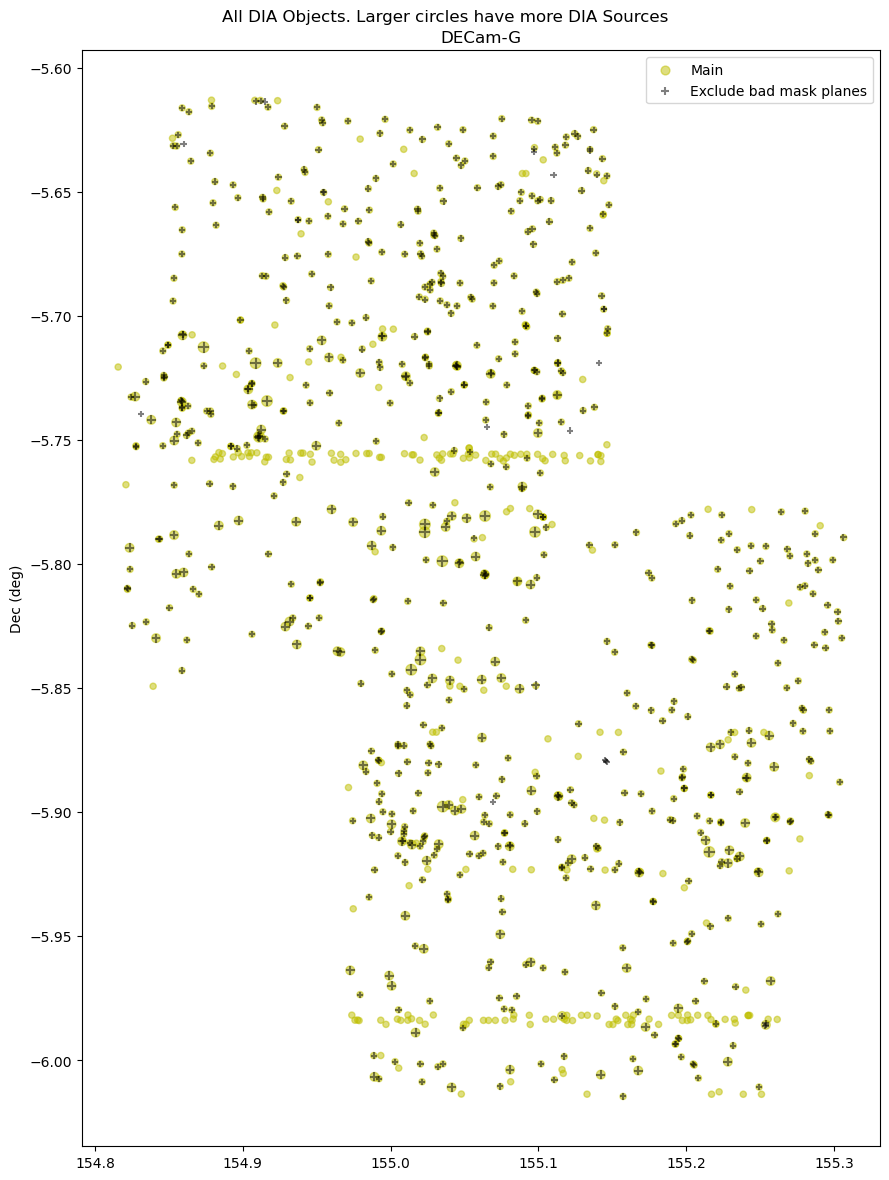

In [65]:
nSrc = 0  # threshold for which DIA Objects to plot (only those with > nSrc constituent DIA Sources)

fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('All DIA Objects. Larger circles have more DIA Sources')

for i_run, run_dict in enumerate([default_run, test_run]):

#     xlim = [149.7, 149.5]
#     ylim = [2.7, 2.9]
    #plt.setp(axs, xlim=xlim, ylim=ylim)
    
    goodFilter = (run_dict['objTable']['nDiaSources'] > nSrc)
#     goodFilter = run_dict[]
    
#     axG = axs[i_run]
    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('DECam-G')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']

    ax.scatter(run_dict['objTable'].loc[goodFilter, 'ra'],
               run_dict['objTable'].loc[goodFilter, 'dec'],
               s=run_dict['objTable'].loc[goodFilter, 'nDiaSources']*20, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

In [66]:
table_test = run_dict['goodObj']

In [67]:
table_test.columns

Index(['diaObjectId', 'ra', 'dec', 'nDiaSources', 'g_psfFluxMean',
       'r_psfFluxMean', 'i_psfFluxMean', 'z_psfFluxMean', 'y_psfFluxMean',
       'validityEnd'],
      dtype='object')

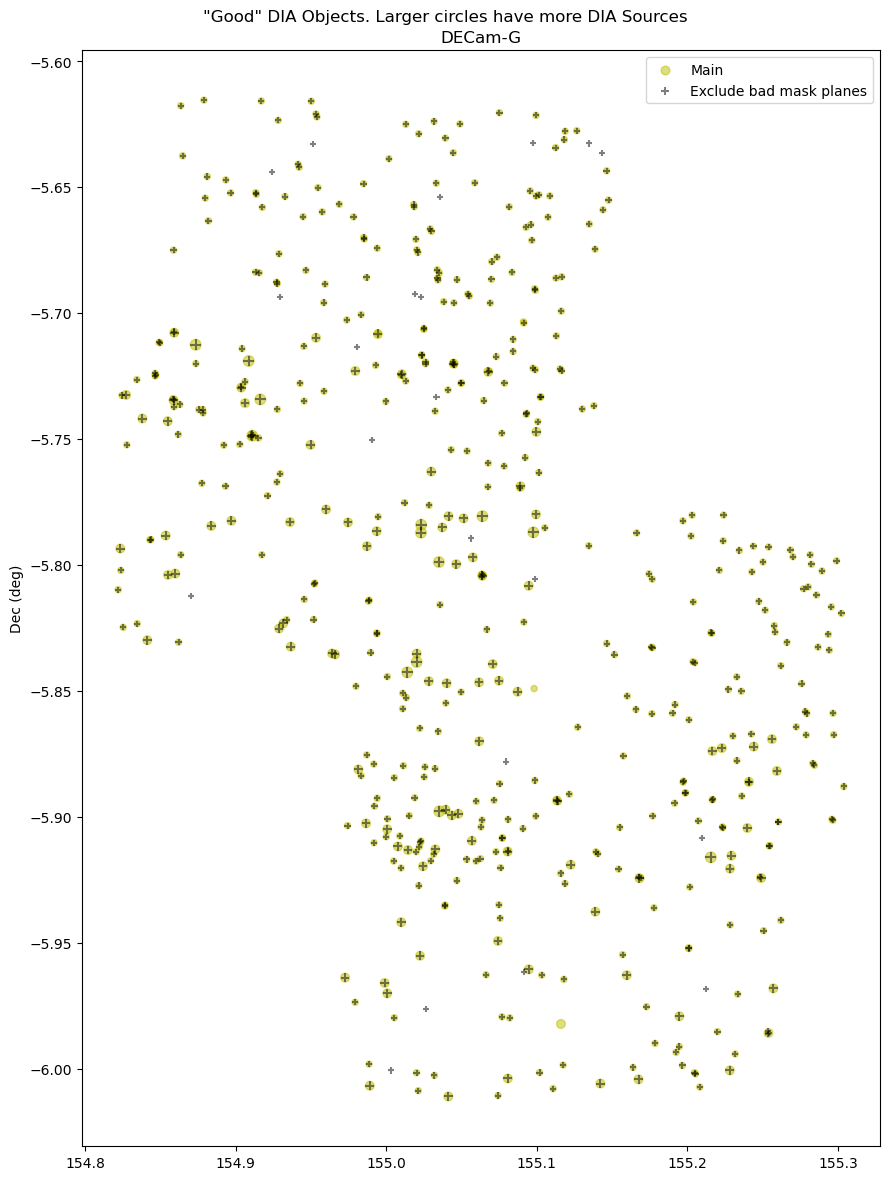

In [68]:
nSrc = 0  # threshold for which DIA Objects to plot (only those with > nSrc constituent DIA Sources)

fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('"Good" DIA Objects. Larger circles have more DIA Sources')

for i_run, run_dict in enumerate([default_run, test_run]):

#     xlim = [149.7, 149.5]
#     ylim = [2.7, 2.9]
    #plt.setp(axs, xlim=xlim, ylim=ylim)
    
    goodFilter = (run_dict['goodObj']['nDiaSources'] > nSrc) &\
                 (run_dict['goodObj']['g_psfFluxMean'] > 0)
#     goodFilter = run_dict[]
    
#     axG = axs[i_run]
    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('DECam-G')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']

    ax.scatter(run_dict['goodObj'].loc[goodFilter, 'ra'],
               run_dict['goodObj'].loc[goodFilter, 'dec'],
               s=run_dict['goodObj'].loc[goodFilter, 'nDiaSources']*20, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

## 4.2 Comparison of diaSources between runs

In [69]:
objectTable1 = default_run['goodObj']
objectTable2 = test_run['goodObj']

In [70]:
objectTable1.columns

Index(['diaObjectId', 'ra', 'dec', 'nDiaSources', 'g_psfFluxMean',
       'r_psfFluxMean', 'i_psfFluxMean', 'z_psfFluxMean', 'y_psfFluxMean',
       'validityEnd'],
      dtype='object')

In [71]:
obj_default, obj_test, obj_match = nb_utils.compare_sources(default_run['butler'], test_run['butler'],
                                                            default_run['reader'], test_run['reader'],
                                                            match_radius=0.2, display_cutouts=False,
                                                            bad_flag_list=badFlagList,
                                                            make_cutouts=False,
                                                            cutout_path1='../../ap_verify_output/tickets/DM-42353/cutouts7',
                                                            cutout_path2='../../ap_verify_output/tickets/DM-42353/cutouts8')

773 matched sources; 5 unique to set 1; 33 unique to set 2.


obj_default_all, obj_test_all, obj_match_all = nb_utils.compare_sources(default_run['butler'], test_run['butler'],
                                                                        default_run['reader'], test_run['reader'],
                                                                        match_radius=0.2, display_cutouts=False,
                                                                        bad_flag_list=None,
                                                                        make_cutouts=True,
                                                                        cutout_path1='../../../project/tickets/DM-40949/cutouts_all_default',
                                                                        cutout_path2='../../../project/tickets/DM-40949/cutouts_all_test')

In [72]:
highObs_default = obj_default.diaSourceId[obj_default['reliability'] > 0.1]

In [73]:
highObs_test = obj_test.diaSourceId[obj_test['reliability'] > 0.1]

In [74]:
len(highObs_default)

0

In [75]:
len(highObs_test)

11

In [76]:
!pwd

/Users/sullivan/LSST/code/ap_pipe-notebooks/notebooks


### 8. diaSource reliability score

Not really part of this ticket, but since we have all the sources available let's compare diaSource reliability scores from real-bogus between runs.

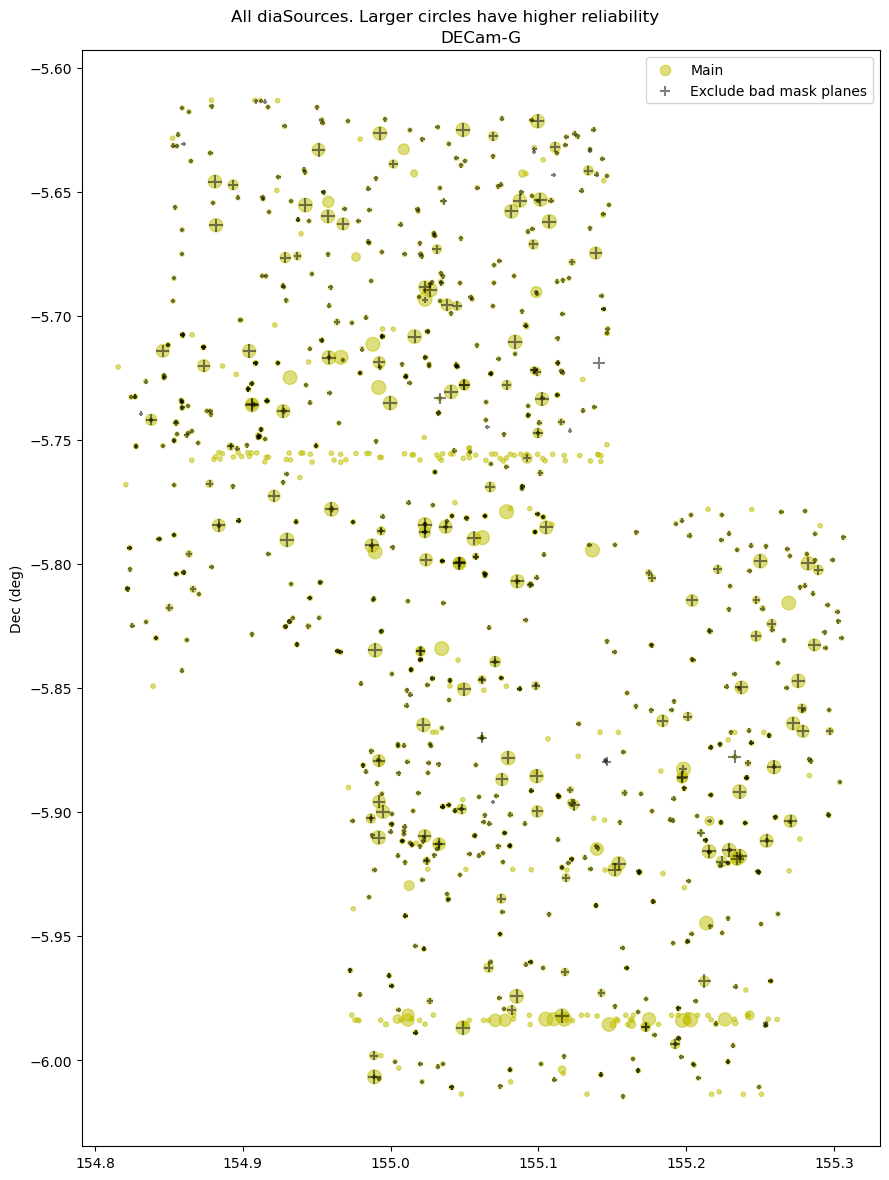

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('All diaSources. Larger circles have higher reliability')

for i_run, run_dict in enumerate([default_run, test_run]):

    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('DECam-G')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']
    sizes = run_dict['srcTable']['reliability']*100
    sizes = [max([s, 10]) for s in sizes]

    ax.scatter(run_dict['srcTable']['ra'],
               run_dict['srcTable']['dec'],
               s=sizes, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

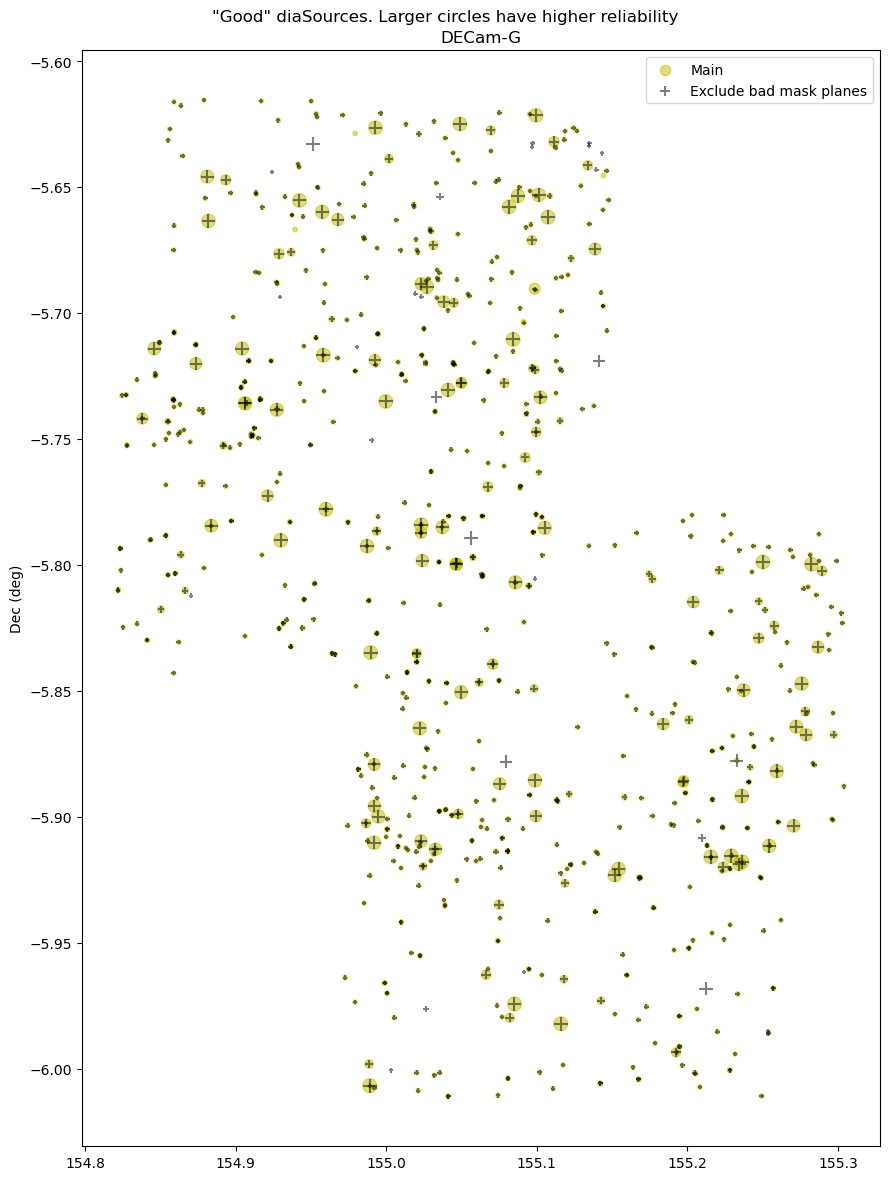

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('"Good" diaSources. Larger circles have higher reliability')

for i_run, run_dict in enumerate([default_run, test_run]):

    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('DECam-G')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']
    sizes = run_dict['goodSrc']['reliability']*100
    sizes = [max([s, 10]) for s in sizes]

    ax.scatter(run_dict['goodSrc']['ra'],
               run_dict['goodSrc']['dec'],
               s=sizes, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

# Load catalog diaSources

Make sure to remove the sky sources first!

In [79]:
butler = default_run['butler']
diaSources7 = []
visit_list7 = []
ccd_list7 = []
for dataId in butler.registry.queryDatasets("goodSeeingDiff_diaSrc"):
    srcCat = butler.get(dataId)
    srcCat = srcCat[~srcCat["sky_source"]]
    diaSources7.append(srcCat.copy(deep=True))
    visit_list7.append(dataId.dataId['visit'])
    ccd_list7.append(dataId.dataId['detector'])

In [80]:
butler = test_run['butler']
diaSources8 = []
visit_list8 = []
ccd_list8 = []
for dataId in butler.registry.queryDatasets("goodSeeingDiff_diaSrc"):
    srcCat = butler.get(dataId)
    srcCat = srcCat[~srcCat["sky_source"]]
    diaSources8.append(srcCat.copy(deep=True))
    visit_list8.append(dataId.dataId['visit'])
    ccd_list8.append(dataId.dataId['detector'])

In [81]:
dataId.dataId['visit']

411420

### Compare catalog diaSources with those in the APDB of each run

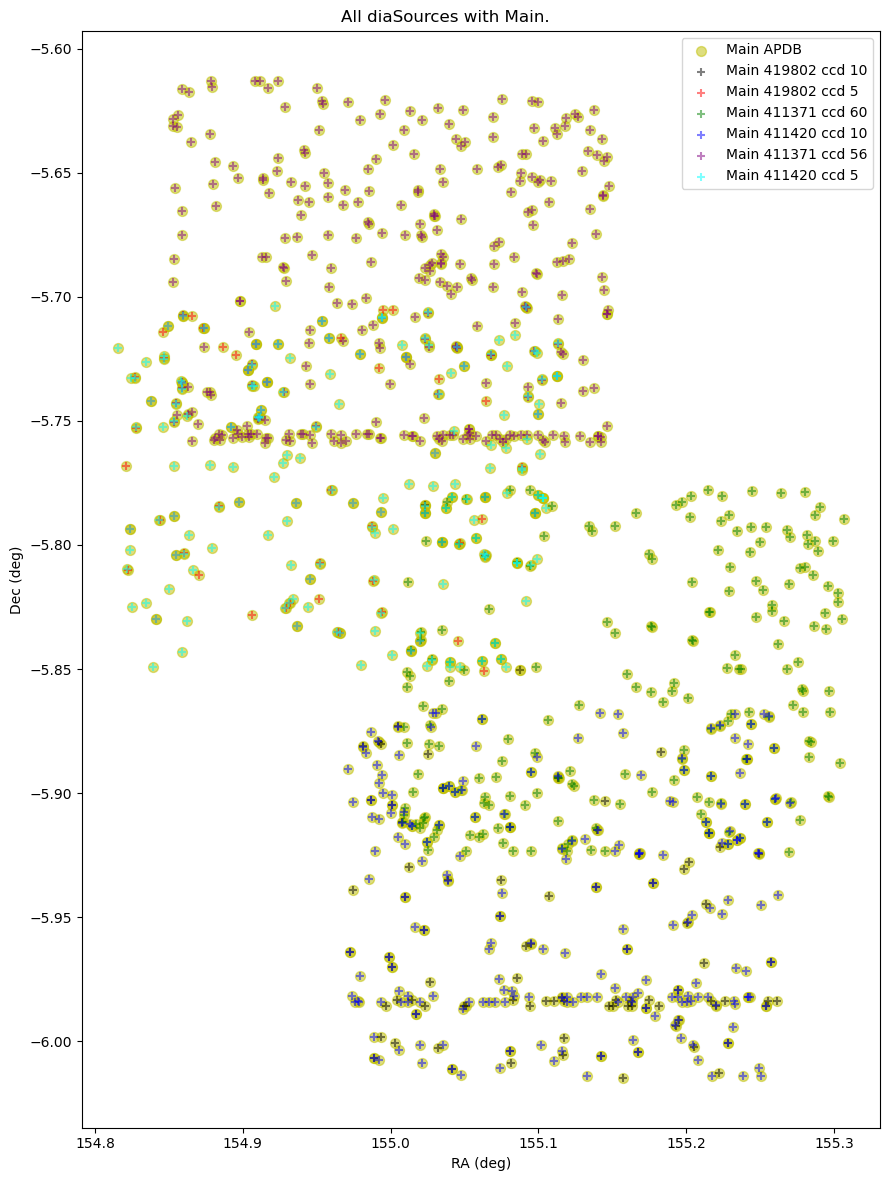

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

run_dict = default_run
run_cat = diaSources7
visit_list = visit_list7
ccd_list = ccd_list7
fig.suptitle(f'All diaSources with {run_dict["run_name"]}.')
ax.set_ylabel('Dec (deg)')

colorList = ['y', 'k', 'r', 'g', 'blue', 'purple', 'cyan']
markerList = ['o', '+']

i_run = 0

ax.scatter(run_dict['srcTable']['ra'],
           run_dict['srcTable']['dec'],
           s=50, 
           c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
           label=run_dict['run_name'] + " APDB")
ax.legend(loc='upper right')

i_run = 1
for i, diaCat in enumerate(run_cat):
    ax.scatter(np.rad2deg(diaCat["coord_ra"]),
               np.rad2deg(diaCat["coord_dec"]),
               s=40, 
               c=colorList[i_run + i], marker=markerList[i_run], alpha=0.5,
               label=f"{run_dict['run_name']} {visit_list[i]} ccd {ccd_list[i]}")
    ax.legend(loc='upper right')
ax.set_xlabel('RA (deg)')
#     axR.legend(loc='upper right')
plt.tight_layout()

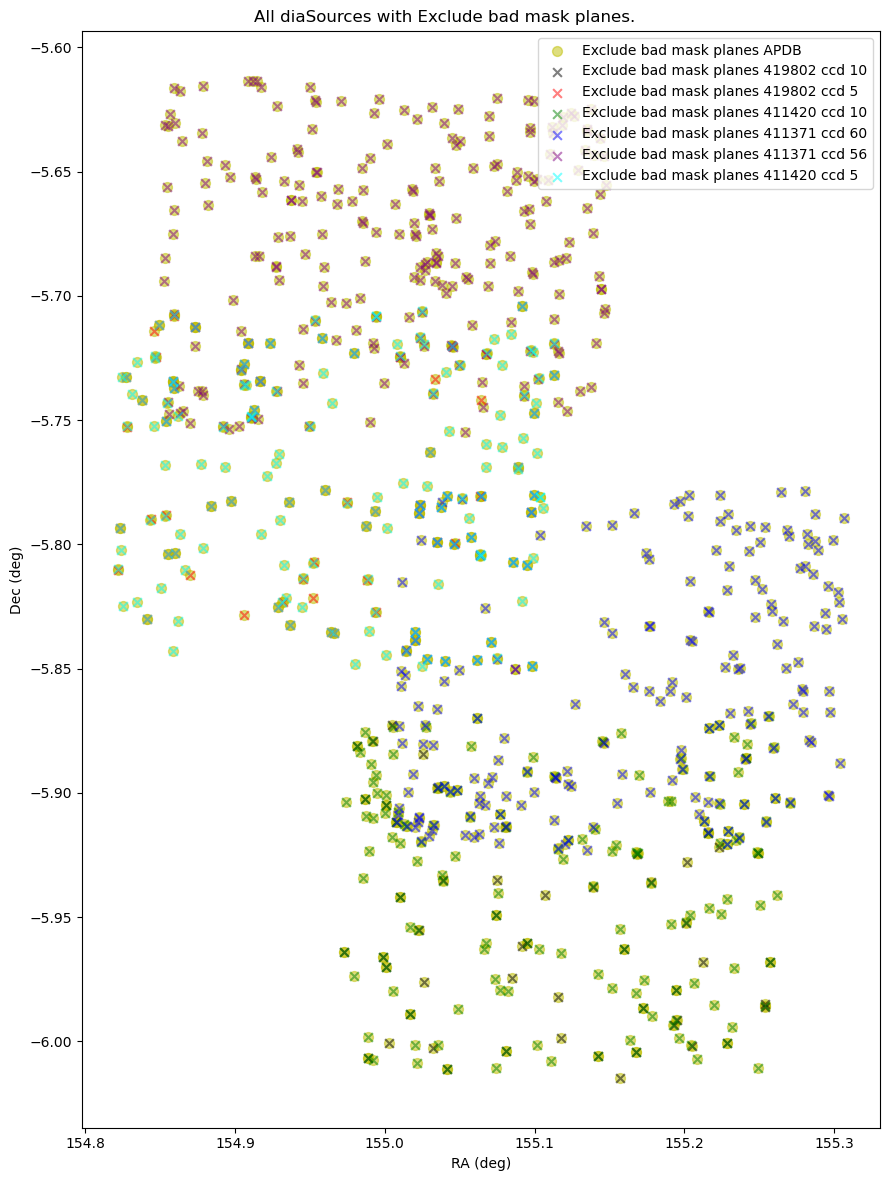

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

run_dict = test_run
run_cat = diaSources8
visit_list = visit_list8
ccd_list = ccd_list8
fig.suptitle(f'All diaSources with {run_dict["run_name"]}.')
ax.set_ylabel('Dec (deg)')

colorList = ['y', 'k', 'r', 'g', 'blue', 'purple', 'cyan']
markerList = ['o','x']

i_run = 0
ax.scatter(run_dict['srcTable']['ra'],
           run_dict['srcTable']['dec'],
           s=50, 
           c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
           label=run_dict['run_name'] + " APDB")
ax.legend(loc='upper right')

i_run = 1
for i, diaCat in enumerate(run_cat):
    ax.scatter(np.rad2deg(diaCat["coord_ra"]),
               np.rad2deg(diaCat["coord_dec"]),
               s=40, 
               c=colorList[i_run + i], marker=markerList[i_run], alpha=0.5,
               label=f"{run_dict['run_name']} {visit_list[i]} ccd {ccd_list[i]}")
    ax.legend(loc='upper right')
ax.set_xlabel('RA (deg)')
#     axR.legend(loc='upper right')
plt.tight_layout()

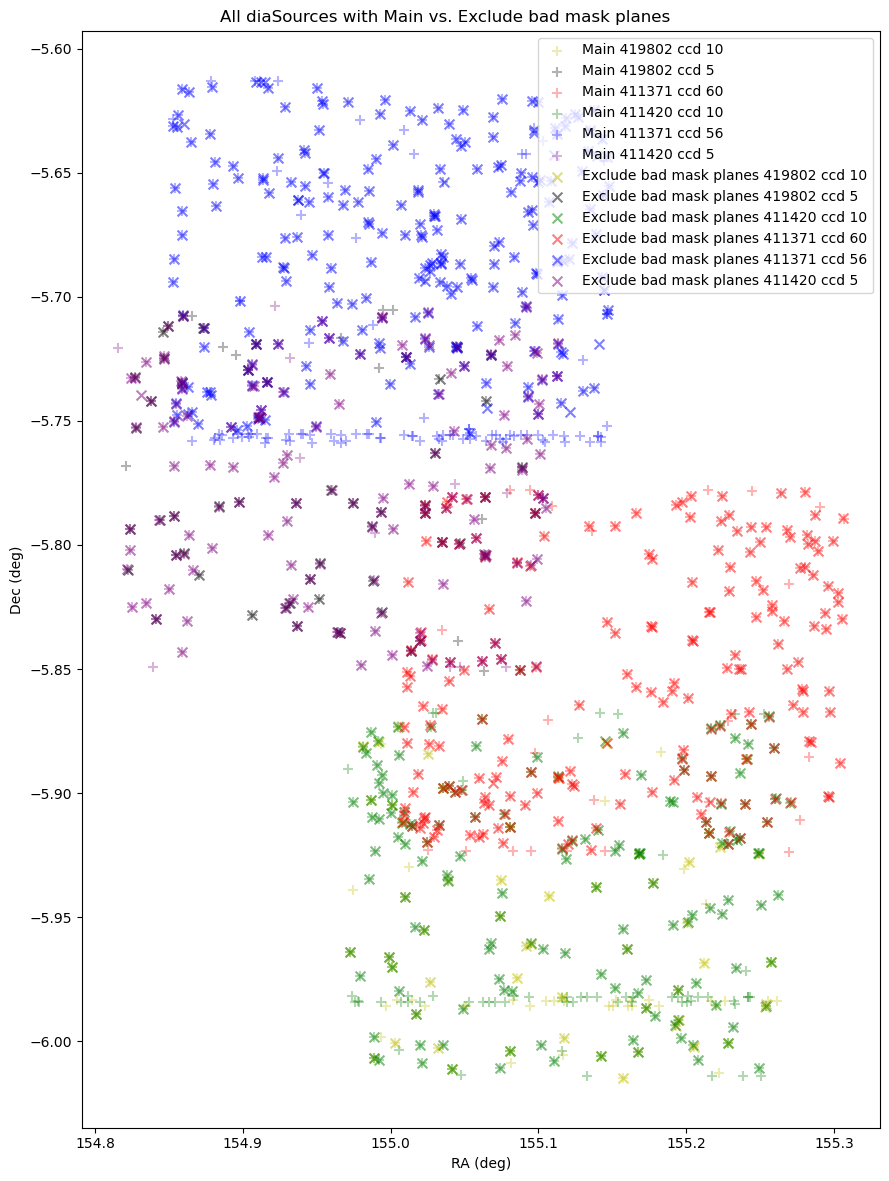

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle(f'All diaSources with {default_run["run_name"]} vs. {test_run["run_name"]}')
ax.set_ylabel('Dec (deg)')

colorList = ['y', 'k', 'r', 'g', 'blue', 'purple', 'cyan']
markerList = ['+', 'x']
color_lookup = {}

i_run = 0
for i, diaCat in enumerate(diaSources7):
    visit = visit_list7[i]
    ccd = ccd_list7[i]
    ref = visit*1000 + ccd
    color_lookup[ref] = i
    ax.scatter(np.rad2deg(diaCat["coord_ra"]),
               np.rad2deg(diaCat["coord_dec"]),
               s=50, 
               c=colorList[i], marker=markerList[i_run], alpha=0.3,
               label=f"{default_run['run_name']} {visit_list7[i]} ccd {ccd_list7[i]}")
    ax.legend(loc='upper right')

i_run = 1
for i, diaCat in enumerate(diaSources8):
    visit = visit_list8[i]
    ccd = ccd_list8[i]
    ref = visit*1000 + ccd
    c = colorList[color_lookup[ref]]
    ax.scatter(np.rad2deg(diaCat["coord_ra"]),
               np.rad2deg(diaCat["coord_dec"]),
               s=50, 
               c=c, marker=markerList[i_run], alpha=0.5,
               label=f"{test_run['run_name']} {visit_list8[i]} ccd {ccd_list8[i]}")
    ax.legend(loc='upper right')
ax.set_xlabel('RA (deg)')
#     axR.legend(loc='upper right')
plt.tight_layout()

# Conclusion